In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

2024-07-16 20:28:04.446844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 20:28:04.446993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 20:28:04.584946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define dataset path and parameters
dataset_path = '/kaggle/input/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Fruits'
img_height, img_width = 224, 224
batch_size = 32
num_classes = 2  # Assuming 2 classes (folders)

class_names = ['FreshOrange', 'RottenOrange']  # Replace with actual class folder names

# Prepare lists for image file paths and labels
file_paths = []
labels = []

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    file_paths.extend([os.path.join(class_path, img) for img in images])
    labels.extend([class_name] * len(images))

# Convert labels to numerical values
label_to_index = {name: index for index, name in enumerate(class_names)}
numeric_labels = [label_to_index[label] for label in labels]


In [3]:
# Split the data into train, validation, and test sets (70% train, 15% validation, 15% test)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    file_paths, numeric_labels, test_size=0.3, random_state=42, stratify=numeric_labels)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

print(f"Number of training examples: {len(train_files)}")
print(f"Number of validation examples: {len(val_files)}")
print(f"Number of test examples: {len(test_files)}")

# Create TensorFlow datasets
def load_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

train_ds1 = tf.data.Dataset.from_tensor_slices((train_files, train_labels)).map(load_image).batch(batch_size)
val_ds1 = tf.data.Dataset.from_tensor_slices((val_files, val_labels)).map(load_image).batch(batch_size)
test_ds1 = tf.data.Dataset.from_tensor_slices((test_files, test_labels)).map(load_image).batch(batch_size)


Number of training examples: 840
Number of validation examples: 180
Number of test examples: 180


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),

])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Apply data augmentation to training dataset
train_ds2 = train_ds1.map(lambda x, y: (data_augmentation(x, training=True), y))

# Preprocess and scale images
train_ds = train_ds2.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds1.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input(x), y))


# MobileNet

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])


model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model and save history
history = model.fit(train_ds, batch_size=32,epochs=100,validation_data=val_ds, callbacks=[early_stopping])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
 3/27 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4340 - loss: 0.9854 

I0000 00:00:1720398567.391910     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 863ms/step - accuracy: 0.6833 - loss: 0.5884 - val_accuracy: 0.9444 - val_loss: 0.2050
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - accuracy: 0.9273 - loss: 0.1978 - val_accuracy: 0.9611 - val_loss: 0.1347
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 474ms/step - accuracy: 0.9584 - loss: 0.1327 - val_accuracy: 0.9556 - val_loss: 0.1156
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 469ms/step - accuracy: 0.9703 - loss: 0.1080 - val_accuracy: 0.9611 - val_loss: 0.0919
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 468ms/step - accuracy: 0.9639 - loss: 0.1089 - val_accuracy: 0.9667 - val_loss: 0.0800
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 468ms/step - accuracy: 0.9612 - loss: 0.0954 - val_accuracy: 0.9778 - val_loss: 0.0753
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - accuracy: 0.9639 - loss: 0.0851 - val_accuracy: 0.9722 - val_loss: 0.0731
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 471ms/step - accuracy: 0.9762 - loss: 0.0714 - val_accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9891 - loss: 0.0265
Test Accuracy: 0.9888888597488403
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

 FreshOrange     1.0000    0.9783    0.9890        92
RottenOrange     0.9778    1.0000    0.9888        88

    accuracy                         0.9889       180
   macro avg     0.9889    0.9891    0.9889       180
weighted avg     0.9891    0.9889    0.9889       180



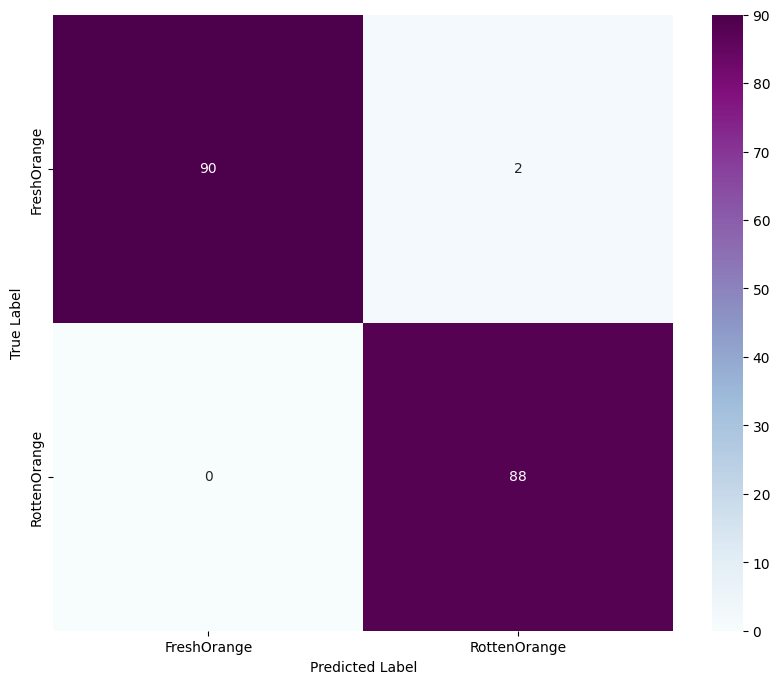

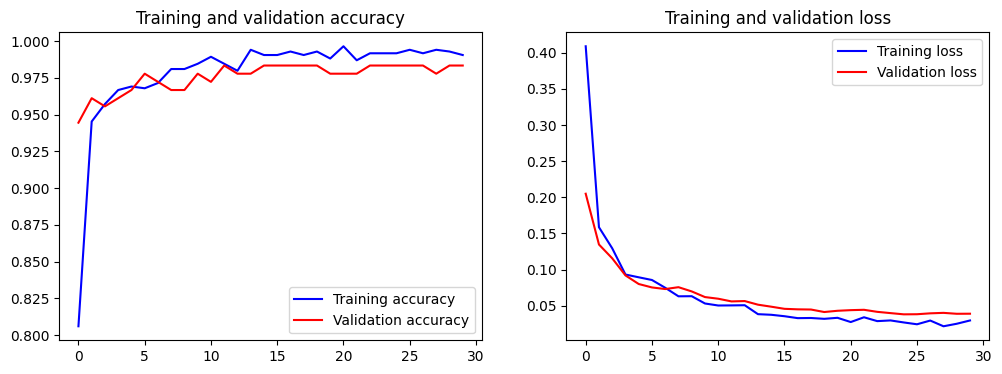

In [6]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# ResNet50

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential



# Preprocess input images for VGG16
def preprocess_input_resnet(x):
    x = tf.keras.applications.resnet.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_resnet(x), y))

val_ds = val_ds1.map(lambda x, y: (preprocess_input_resnet(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_resnet(x), y))



# Load ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5892 - loss: 0.7264

W0000 00:00:1720399009.961235     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.7343 - loss: 0.5047

W0000 00:00:1720399028.354025      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 884ms/step - accuracy: 0.7380 - loss: 0.4989 - val_accuracy: 0.9500 - val_loss: 0.1472
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.9678 - loss: 0.1194 - val_accuracy: 0.9722 - val_loss: 0.0894
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.9615 - loss: 0.1000 - val_accuracy: 0.9778 - val_loss: 0.0666
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 494ms/step - accuracy: 0.9877 - loss: 0.0526 - val_accuracy: 0.9833 - val_loss: 0.0612
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 491ms/step - accuracy: 0.9796 - loss: 0.0557 - val_accuracy: 0.9778 - val_loss: 0.0580
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.9853 - loss: 0.0469 - val_accuracy: 0.9833 - val_loss: 0.0551
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 486ms/step - accuracy: 0.9912 - loss: 0.0388 - val_accuracy: 0.9889 - val_loss: 0.0468
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.9919 - loss: 0.0313 - val_accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0082
Test Accuracy: 1.0
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

 FreshOrange     1.0000    1.0000    1.0000        92
RottenOrange     1.0000    1.0000    1.0000        88

    accuracy                         1.0000       180
   macro avg     1.0000    1.0000    1.0000       180
weighted avg     1.0000    1.0000    1.0000       180



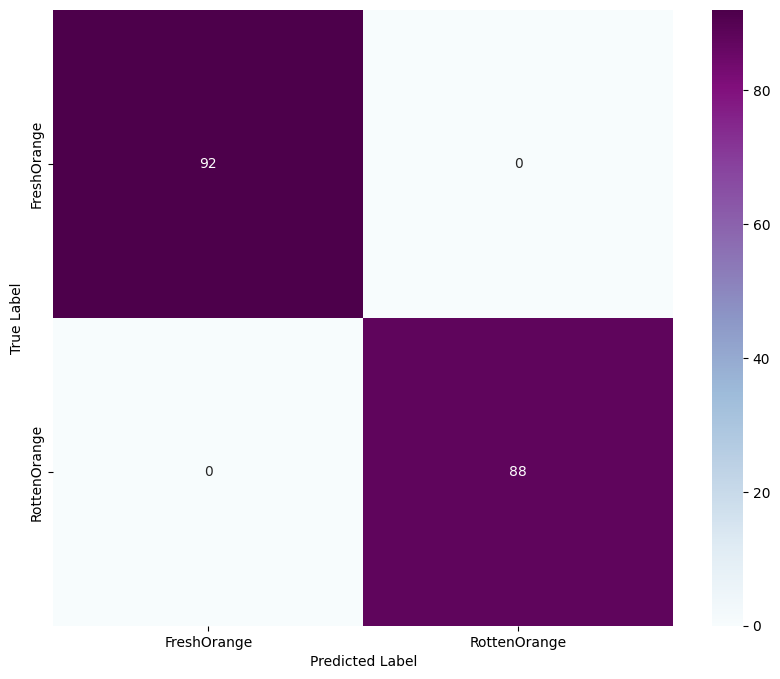

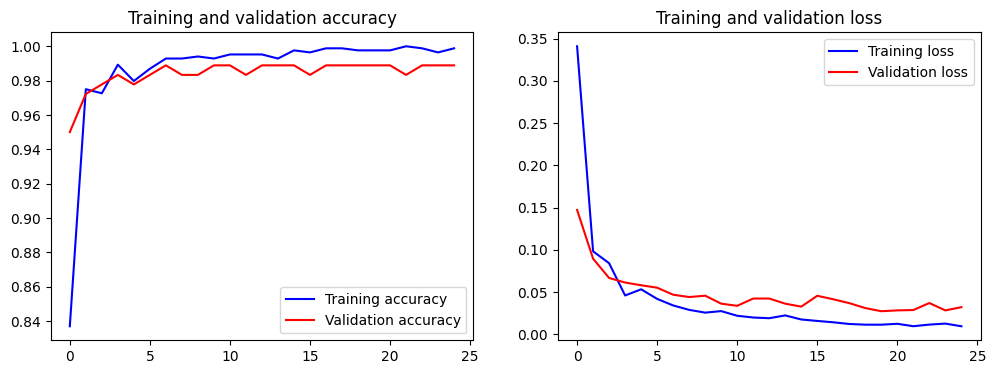

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# VGG16

In [9]:
from tensorflow.keras.applications import VGG16

# Preprocess input images for VGG16
def preprocess_input_vgg(x):
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_vgg(x), y))

val_ds = val_ds1.map(lambda x, y: (preprocess_input_vgg(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_vgg(x), y))


# Assuming you have defined img_height, img_width, num_classes, train_ds, and val_ds appropriately

# Load VGG16 model with pre-trained ImageNet weights
base_model = VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


2024-07-08 00:43:16.154816: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-08 00:43:16.155620: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-08 00:43:16.155670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-08 00:43:16.155686: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-08 00:43:16.155705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-07-08 00:43:16.155723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-07-08 00:43:16.155739: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-07-08 00:43:16.155753: E external/local_xla/xla/se

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6631 - loss: 4.5334

2024-07-08 00:43:41.978220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.39009, expected 3.53025
2024-07-08 00:43:41.978268: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.40727, expected 4.54742
2024-07-08 00:43:41.978278: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.56026, expected 4.70042
2024-07-08 00:43:41.978287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.58812, expected 4.72827
2024-07-08 00:43:41.978295: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.9643, expected 4.10445
2024-07-08 00:43:41.978303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.19898, expected 4.33914
2024-07-08 00:43:41.978311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.47066, expected 4.61082
2024-07-08 00:43:41.978319: 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6650 - loss: 4.4857

2024-07-08 00:43:48.923116: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.79983, expected 3.15789
2024-07-08 00:43:48.923163: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.13466, expected 4.49272
2024-07-08 00:43:48.923173: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.78155, expected 4.13961
2024-07-08 00:43:48.923181: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.88295, expected 4.24101
2024-07-08 00:43:48.923190: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.73279, expected 4.09085
2024-07-08 00:43:48.923215: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.69943, expected 4.05749
2024-07-08 00:43:48.923224: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.1975, expected 3.55556
2024-07-08 00:43:48.923247: 

27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6667 - loss: 4.4414 - val_accuracy: 0.7500 - val_loss: 6.9095
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.8003 - loss: 1.5121 - val_accuracy: 0.8444 - val_loss: 5.2778
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.8381 - loss: 1.5335 - val_accuracy: 0.8944 - val_loss: 3.1171
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.8253 - loss: 1.6437 - val_accuracy: 0.8778 - val_loss: 3.3470
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 493ms/step - accuracy: 0.8470 - loss: 1.3302 - val_accuracy: 0.9111 - val_loss: 1.8649
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 489ms/step - accuracy: 0.8847 - loss: 1.2850 - val_accuracy: 0.9111 - val_loss: 2.2248
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 487ms/step - accuracy: 0.8884 - loss: 0.9436 - val_accuracy: 0.9056 - val_loss: 2.0076
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 486ms/step - accuracy: 0.9087 - loss: 0.6641 - val_accuracy: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9122 - loss: 0.9552
Test Accuracy: 0.8999999761581421
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
              precision    recall  f1-score   support

 FreshOrange     0.9022    0.9022    0.9022        92
RottenOrange     0.8977    0.8977    0.8977        88

    accuracy                         0.9000       180
   macro avg     0.9000    0.9000    0.9000       180
weighted avg     0.9000    0.9000    0.9000       180



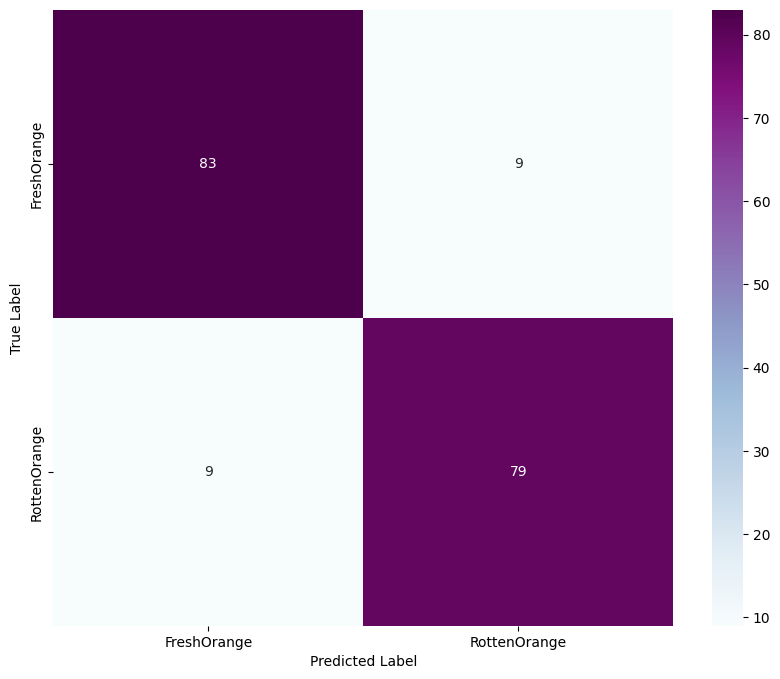

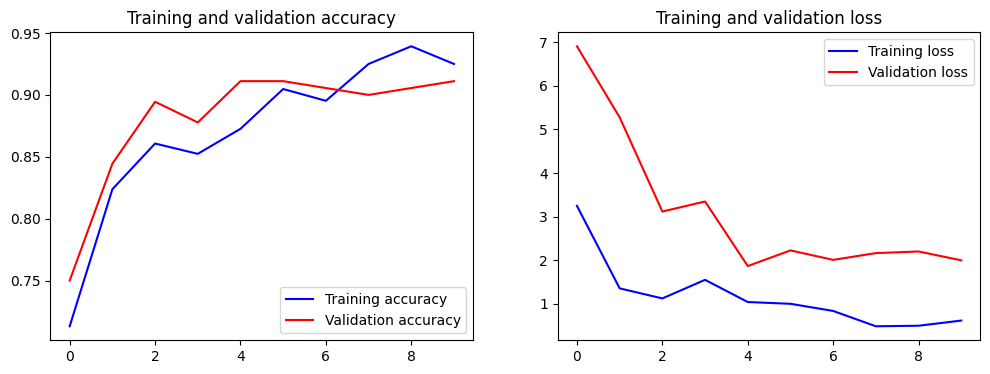

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

In [11]:
# Unfreeze some layers of ResNet50 for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 592ms/step - accuracy: 0.8658 - loss: 1.3753 - val_accuracy: 0.9167 - val_loss: 2.0353
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.9438 - loss: 0.5208 - val_accuracy: 0.9389 - val_loss: 3.1743
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.8756 - loss: 0.8529 - val_accuracy: 0.9333 - val_loss: 2.8185
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 491ms/step - accuracy: 0.9358 - loss: 0.3495 - val_accuracy: 0.9667 - val_loss: 1.1131
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 493ms/step - accuracy: 0.9784 - loss: 0.0657 - val_accuracy: 0.9611 - val_loss: 0.8572
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 489ms/step - accuracy: 0.9630 - loss: 0.0865 - val_accuracy: 0.9667 - val_loss: 0.7913
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 510ms/step - accuracy: 0.9729 - loss: 0.0811 - val_accuracy: 0.9611 - val_loss: 0.7879
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 506ms/step - accuracy: 0.9877 - loss: 0.0250 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9948 - loss: 0.1795
Test Accuracy: 0.9888888597488403
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
              precision    recall  f1-score   support

 FreshOrange     0.9787    1.0000    0.9892        92
RottenOrange     1.0000    0.9773    0.9885        88

    accuracy                         0.9889       180
   macro avg     0.9894    0.9886    0.9889       180
weighted avg     0.9891    0.9889    0.9889       180



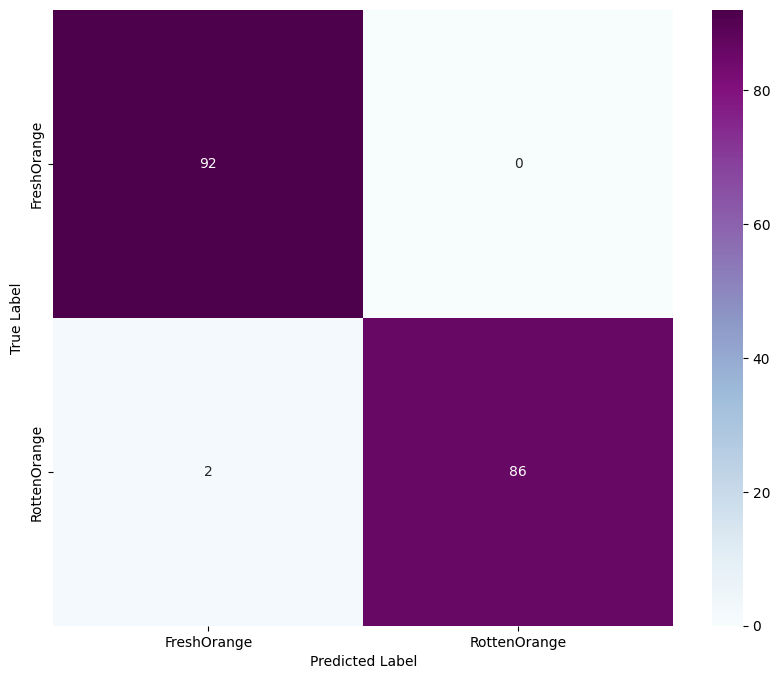

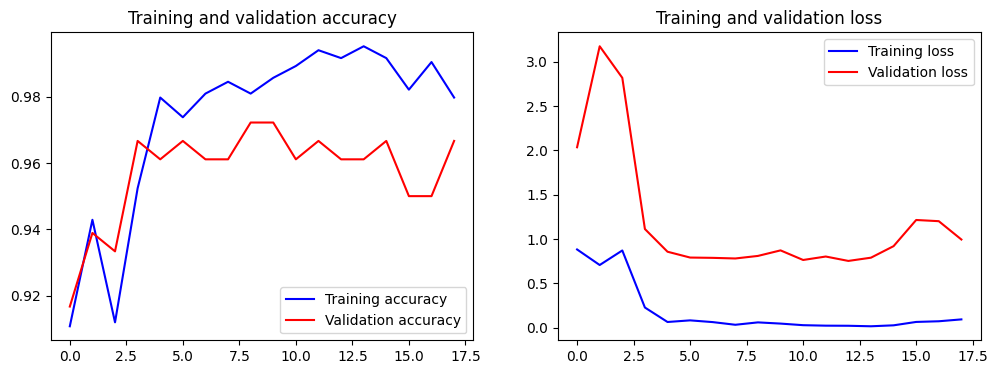

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# EfficientNetB0

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Preprocess input images for EfficientNet
def preprocess_input_efficientnet(x):
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x

train_ds = train_ds2.map(lambda x, y: (preprocess_input_efficientnet(x), y))
val_ds = val_ds1.map(lambda x, y: (preprocess_input_efficientnet(x), y))
test_ds = test_ds1.map(lambda x, y: (preprocess_input_efficientnet(x), y))

# Load EfficientNetB7 model with pre-trained ImageNet weights
base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add layers on top of the base model
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

# Create the model
model = Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and save history
history = model.fit(train_ds, batch_size=32, epochs=100, validation_data=val_ds, callbacks=[early_stopping])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
 1/27 ━━━━━━━━━━━━━━━━━━━━ 14:22 33s/step - accuracy: 0.5312 - loss: 0.7174

I0000 00:00:1721161732.180610     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7585 - loss: 0.5152 - val_accuracy: 0.9556 - val_loss: 0.1917
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 474ms/step - accuracy: 0.9332 - loss: 0.2049 - val_accuracy: 0.9722 - val_loss: 0.1209
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 477ms/step - accuracy: 0.9627 - loss: 0.1397 - val_accuracy: 0.9778 - val_loss: 0.0978
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - accuracy: 0.9563 - loss: 0.1230 - val_accuracy: 0.9722 - val_loss: 0.0869
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 468ms/step - accuracy: 0.9580 - loss: 0.1108 - val_accuracy: 0.9778 - val_loss: 0.0725
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 470ms/step - accuracy: 0.9689 - loss: 0.0839 - val_accuracy: 0.9722 - val_loss: 0.0690
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 478ms/step - accuracy: 0.9702 - loss: 0.0921 - val_accuracy: 0.9722 - val_loss: 0.0624
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 467ms/step - accuracy: 0.9632 - loss: 0.0848 - val_accuracy: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0235
Test Accuracy: 1.0
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
              precision    recall  f1-score   support

 FreshOrange     1.0000    1.0000    1.0000        92
RottenOrange     1.0000    1.0000    1.0000        88

    accuracy                         1.0000       180
   macro avg     1.0000    1.0000    1.0000       180
weighted avg     1.0000    1.0000    1.0000       180



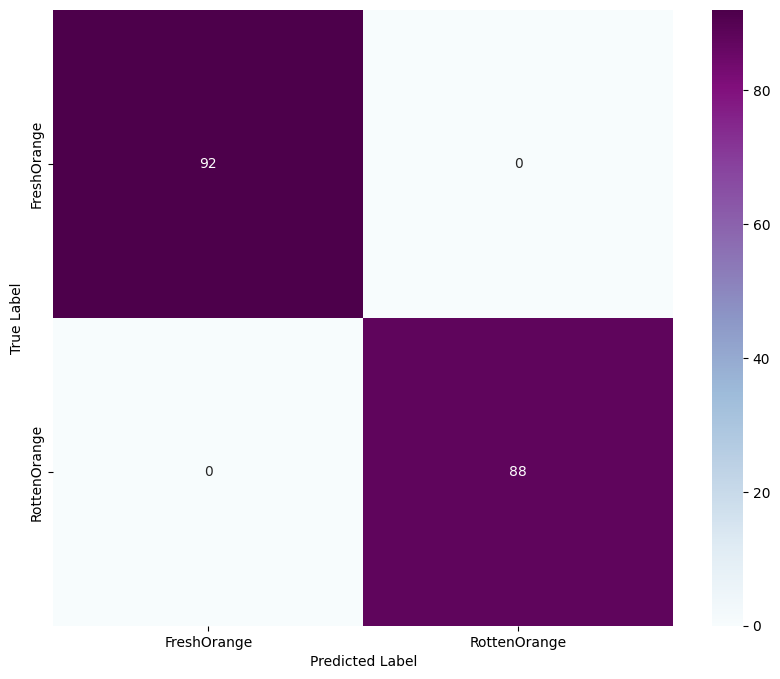

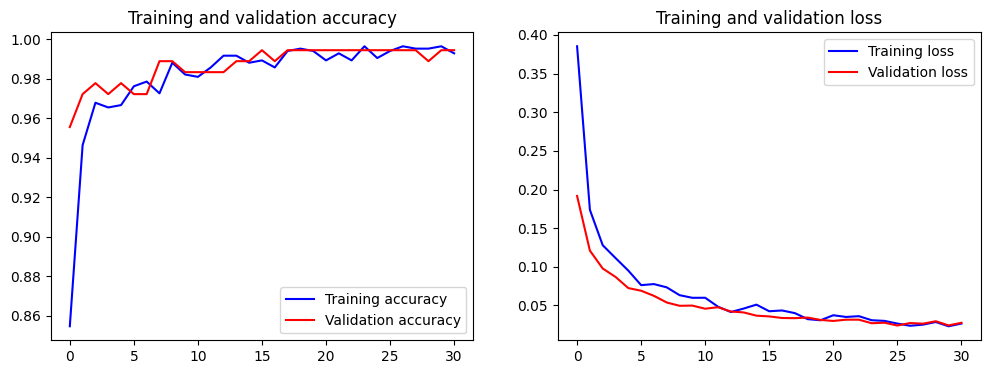

In [6]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")
print("--------------------")

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names,  digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# calculate the percentage
#cm_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)